#### Test Configuration

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cpu


In [ ]:
base_model = "distilbert-base-uncased"
test_model = "models/SemanticVAD_2.pt"
NUM_LABELS = 2
device = "cpu"
test_data = "./dataset/test_data_clean_truncated.csv"
round = 50

#### Load Model

⚠️ Notice: change the corresponding parameters in the constructor of 'DistilHuBERTClassifier' of train.py to match the testing model.

In [3]:
from transformers import DistilBertModel
import torch.nn as nn

class DistilBERTBackchannelScorer(nn.Module):
    def __init__(self, hidden_dim=768):
        super().__init__()
        self.encoder = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # CLS token
        logits = self.classifier(pooled).squeeze(-1)  # shape: (batch_size,)
        loss = None
        if labels is not None:
            labels = labels.float()  # BCE loss 要求 float
            loss = nn.BCEWithLogitsLoss()(logits, labels)
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits
        )

In [4]:
import torch
from transformers import AutoModel

encoder = AutoModel.from_pretrained(base_model)
model = DistilBERTBackchannelScorer()
model.load_state_dict(torch.load(test_model, map_location=device))
model.eval()

DistilBERTBackchannelScorer(
  (encoder): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
           

#### Construct Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CSVTestDataset(Dataset):
    def __init__(self, csv_path, tokenizer, max_length=128):
        df = pd.read_csv(csv_path)
        df = df.dropna(subset=["text"])
        df["text"] = df["text"].astype(str).str.replace(r"\[.*?\]", "", regex=True).str.strip()

        self.labels = df["labels"].tolist()
        self.encodings = tokenizer(
            df["text"].tolist(),
            truncation=True,
            padding="max_length",
            max_length=max_length
        )

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label

In [6]:
def collate_fn(batch):
    input_ids = torch.stack([x[0] for x in batch])
    attention_mask = torch.stack([x[1] for x in batch])
    labels = torch.stack([x[2] for x in batch])
    return input_ids, attention_mask, labels

In [7]:
import pandas as pd
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
test_dataset = CSVTestDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn)

#### Memory/Time Test For Mac (CPU/GPU Uniform)

In [8]:
import torch

if device == "cuda":
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Max VRAM:       {torch.cuda.max_memory_allocated() / 1024**2:.2f} MB")

In [9]:
import psutil
process = psutil.Process()
print(f"RSS Memory: {process.memory_info().rss / 1024**2:.2f} MB")

RSS Memory: 971.30 MB


In [10]:
import time
import psutil
import os
import torch
import numpy as np
from transformers.modeling_outputs import SequenceClassifierOutput

process = psutil.Process(os.getpid())

all_probs = []
all_preds = []
all_labels = []

memory_used = []
memory_cost = []
time_cost = []

sum_time = 0
sum_memory_cost = 0

model.eval()
model.to(device)

    
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        if i >= round:
            break
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        before = process.memory_info().rss
        start = time.time()

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits.view(-1)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

        end = time.time()
        after = process.memory_info().rss

        mem_delta = after - before
        infer_time = end - start

        memory_used.append(before / 1024 / 1024)
        memory_cost.append(mem_delta / 1024 / 1024)
        time_cost.append(infer_time)

        sum_time += infer_time
        sum_memory_cost += mem_delta

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

        for idx in range(len(labels)):
            print(f"Sample {i * len(labels) + idx} | True: {labels[idx].item()} | Pred: {preds[idx].item()} | Prob: {probs[idx]:.4f} | Time: {infer_time:.4f}s | ΔMem: {mem_delta / 1024 / 1024:.2f}MB")

avg_time = sum_time / len(test_loader.dataset)
avg_mem = sum_memory_cost / 1024 / 1024 / len(test_loader.dataset)

print("\n📊 Evaluation Summary")
print(f"🔢 Samples Evaluated: {len(test_loader.dataset)}")
print(f"🕒 Total Inference Time: {sum_time:.2f} s")
print(f"⏱️  Avg Inference Time per Sample: {avg_time:.4f} s")
print(f"🧠 Total Memory Cost: {sum_memory_cost / 1024 / 1024:.2f} MB")
print(f"🧠 Avg Memory per Sample: {avg_mem:.2f} MB")

Sample 0 | True: 0.0 | Pred: 0 | Prob: 0.0126 | Time: 0.0203s | ΔMem: 16.20MB
Sample 1 | True: 0.0 | Pred: 0 | Prob: 0.0279 | Time: 0.0197s | ΔMem: 1.47MB
Sample 2 | True: 0.0 | Pred: 1 | Prob: 0.9931 | Time: 0.0174s | ΔMem: 4.36MB
Sample 3 | True: 0.0 | Pred: 0 | Prob: 0.0118 | Time: 0.0191s | ΔMem: 0.39MB
Sample 4 | True: 0.0 | Pred: 1 | Prob: 0.9929 | Time: 0.0181s | ΔMem: 0.66MB
Sample 5 | True: 0.0 | Pred: 0 | Prob: 0.0134 | Time: 0.0189s | ΔMem: 1.12MB
Sample 6 | True: 0.0 | Pred: 1 | Prob: 0.6556 | Time: 0.0199s | ΔMem: 0.02MB
Sample 7 | True: 0.0 | Pred: 1 | Prob: 0.9931 | Time: 0.0182s | ΔMem: 0.00MB
Sample 8 | True: 0.0 | Pred: 0 | Prob: 0.0119 | Time: 0.0187s | ΔMem: 3.02MB
Sample 9 | True: 0.0 | Pred: 1 | Prob: 0.9926 | Time: 0.0174s | ΔMem: 1.38MB
Sample 10 | True: 0.0 | Pred: 0 | Prob: 0.0121 | Time: 0.0187s | ΔMem: 0.00MB
Sample 11 | True: 0.0 | Pred: 1 | Prob: 0.9919 | Time: 0.0184s | ΔMem: 0.08MB
Sample 12 | True: 0.0 | Pred: 0 | Prob: 0.0124 | Time: 0.0191s | ΔMem: 0.

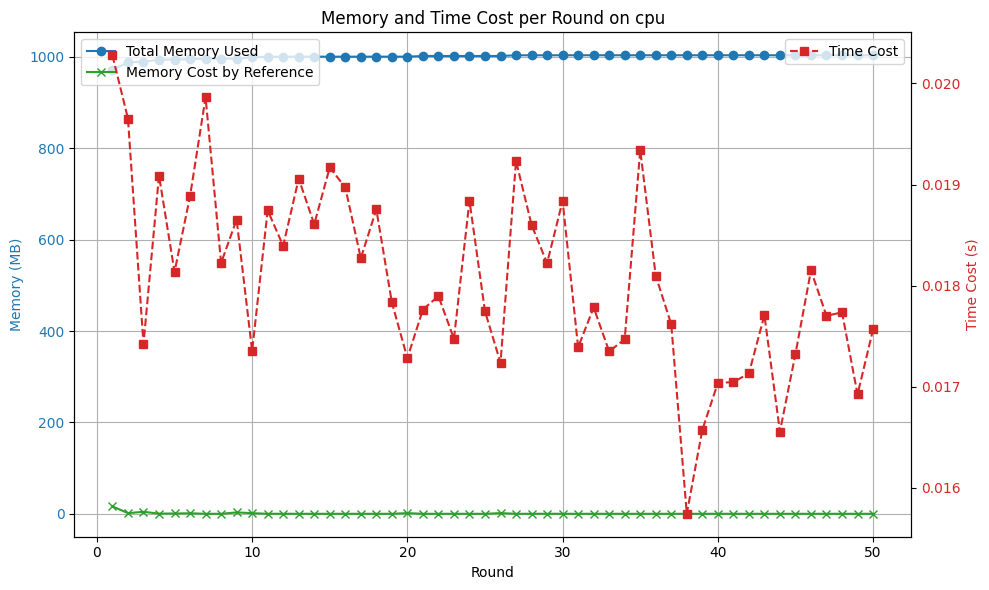

🧠 Total memory cost by reference: 31.77 MB
⏱️  Average time cost: 18.05 ms


In [11]:
import matplotlib.pyplot as plt

rounds = list(range(1, len(memory_used) + 1))
num_rounds = len(rounds)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Memory curves
color1 = 'tab:blue'
color2 = 'tab:green'
ax1.set_xlabel('Round')
ax1.set_ylabel('Memory (MB)', color=color1)
ax1.plot(rounds, memory_used, marker='o', color=color1, label='Total Memory Used')
ax1.plot(rounds, memory_cost, marker='x', color=color2, label='Memory Cost by Reference')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True)
ax1.legend(loc='upper left')

# Time cost on second axis
ax2 = ax1.twinx()
color3 = 'tab:red'
ax2.set_ylabel('Time Cost (s)', color=color3)
ax2.plot(rounds, time_cost, marker='s', linestyle='--', color=color3, label='Time Cost')
ax2.tick_params(axis='y', labelcolor=color3)
ax2.legend(loc='upper right')

plt.title(f'Memory and Time Cost per Round on {device}')
fig.tight_layout()
plt.show()

# Stats summary
print(f"🧠 Total memory cost by reference: {sum_memory_cost / 1024 / 1024:.2f} MB")
print(f"⏱️  Average time cost: {(sum_time) / num_rounds * 1000:.2f} ms")